In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import normalize
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read in dataset and select columns
terror = pd.read_csv('../../terrorism_new.csv')

cols = [
    'success','eventid','extended',
    'attacktype1_txt','weaptype1_txt','targtype1_txt',
    'claimed','gname','suicide','nperps',
    'nkill','nwound','property','propextent','propvalue'
]

numeric_cols = [
    'nkill','nwound','nperps','propvalue'
]

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# herlper functions
unknown_map = {
    # TODO: update as i go along
    "nperps":-99,
    "propvalue":-99,
}


def filterColumnsAndRows(df, cols, mapping):
    df = df[cols].dropna()
    for col in cols:
        if col in mapping:
            df = df[df[col] != mapping[col]]
    return df

def getDendrogram(features):
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(features, method='ward'))
    
def getClusterStats(features, num_clusters, cols):
    cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
    features['cluster'] =  cluster.fit_predict(features)
    feature_stats = features.groupby('cluster')[cols].mean()
    ax = sns.heatmap(feature_stats)
    return features, feature_stats

def plotHistogramForCluster(df, cluster, col):
    df = df[df['cluster'] == cluster]\
    .groupby(col)['eventid']\
    .count()\
    .to_frame()\
    .reset_index()\
    .sort_values('eventid',ascending=False)

    plt.figure(figsize=(20,10))

    df_plot = sns.barplot(x=col, y="eventid", palette="rocket", data=df)
    for item in df_plot.get_xticklabels():
        item.set_rotation(45)
    plt.title(f"Distribution of {col} for cluster {cluster}")

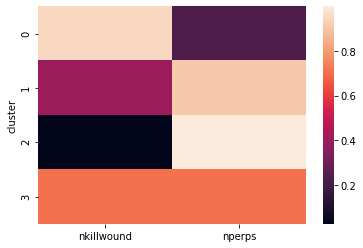

In [4]:
df2 = filterColumnsAndRows(terror, ['eventid','nkill', 'nwound', 'nperps'], unknown_map)
df2['nkillwound'] = df2['nkill'] + df2['nwound']
features = pd.DataFrame(normalize(df2[['nkillwound', 'nperps']]),columns = ['nkillwound', 'nperps'])
features, feature_stats = getClusterStats(features, 4, ['nkillwound', 'nperps'])

In [5]:
features.head()

,nkillwound,nperps,cluster
0,0.0,1.0,2
1,0.0,1.0,2
2,0.0,1.0,2
3,0.0,1.0,2
4,0.0,1.0,2


In [6]:
features['cluster'].value_counts()

2    9742
0    7770
1    6118
3    4509
Name: cluster, dtype: int64

In [7]:
df2['cluster'] = features['cluster'].values
clusters = df2[['eventid','cluster']].merge(terror[cols], on = 'eventid')

In [8]:
def plotStackedBar(df, col, num_clusters):
    plt.figure(figsize=(20,10))
    df = df[['eventid',col,'cluster']]\
    .groupby([col,"cluster"])['eventid']\
    .count()\
    .to_frame()\
    .reset_index()
    df = pd.pivot_table(df,values='eventid',index=[col],columns=['cluster'])
    df.columns = [str(i) for i in range(num_clusters)]

    labels = list(df.index)
    idx = np.arange(len(labels))
    total = [sum(arr) for arr in zip(*[df[str(i)] for i in range(num_clusters)])]
    plt.figure(figsize=(20,10))
    width = 0.85
    colors = ['#F8B195','#F67280','#C06C84','#355C7D']
    bars = [[j / k * 100 for j,k in zip(df[str(i)], total)] for i in range(num_clusters)]
    bottom = np.zeros(len(labels))
    for i in range(num_clusters):
        plt.bar(idx, bars[i], bottom=bottom, color=colors[i], edgecolor='white', width=width,label=f'cluster {i}')
        bottom += bars[i]
    plt.xticks(idx, labels, rotation=45)
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.legend()
    plt.show()

<Figure size 1440x720 with 0 Axes>

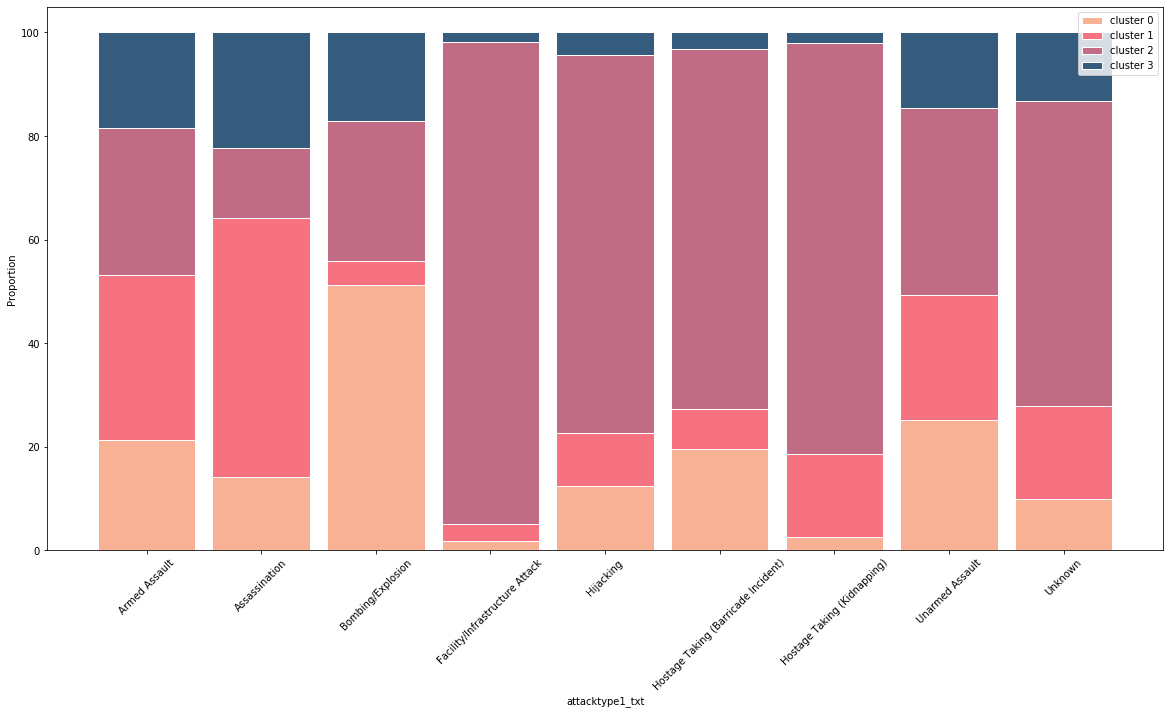

In [9]:
plotStackedBar(clusters, "attacktype1_txt", 4)

<Figure size 1440x720 with 0 Axes>

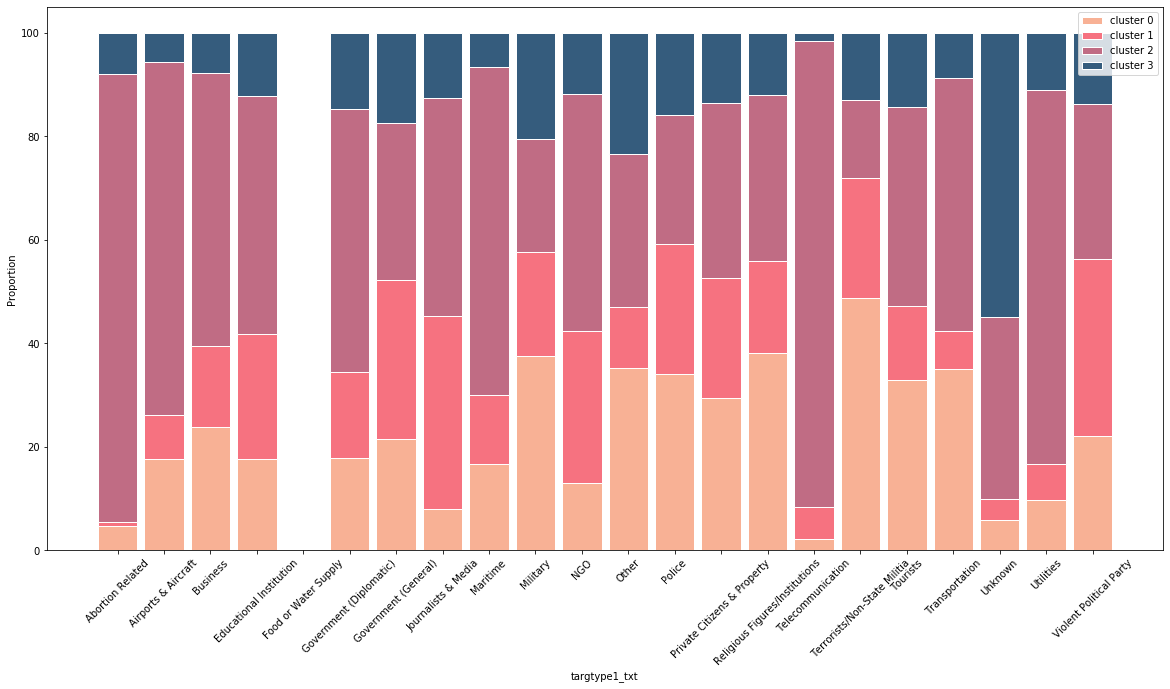

In [10]:
plotStackedBar(clusters, "targtype1_txt", 4)

In [11]:
# Assign cluster labels to the filtered rows
merged = pd.merge(terror, clusters[["eventid","cluster"]], on='eventid', how='left')
merged.sample(5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,cluster
102124,201106220012,2011,6,22,NaN,0,NaN,95,Iraq,10,...,"Xinhua News Agency, ""Civilian Killed, 27 Injur...","Margaret Griffis, ""Wednesday: 13 Iraqis Killed...","Reuters, ""FACTBOX- Security Developments in Ir...",ISVG,-9,-9,0,-9,NaN,NaN
97552,201007310005,2010,7,31,NaN,0,NaN,95,Iraq,10,...,"Reuters, ""FACTBOX- Security Developments in Ir...",NaN,NaN,ISVG,-9,-9,0,-9,NaN,NaN
9034,197908050002,1979,8,5,NaN,0,NaN,97,Israel,10,...,NaN,NaN,NaN,PGIS,1,0,0,1,NaN,NaN
179877,201710150042,2017,10,15,NaN,1,NaN,195,Sudan,11,...,"""Boy, man abducted in North Darfur,"" DABANGA, ...",NaN,NaN,START Primary Collection,-9,-9,1,1,NaN,NaN
87733,200807020018,2008,7,2,NaN,1,7/22/2008,92,India,6,...,"United News of India, ""Two Nhai Engineers Abdu...","National Counterterrorism Center, ""Three Civil...","South Asia Terrorism Portal, ""Two Persons Abdu...",ISVG,0,0,0,0,NaN,NaN


In [12]:
# Summary of the 'cluster' column in merged df
print(merged['cluster'].value_counts())
print(merged['cluster'].isnull().value_counts())

2.0    9742
0.0    7770
1.0    6118
3.0    4509
Name: cluster, dtype: int64
True     163325
False     28139
Name: cluster, dtype: int64


In [13]:
labelled = merged[merged['cluster'].notna()]
unlabelled = merged[merged['cluster'].isnull()]

display(labelled.head())
unlabelled.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,cluster
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,2.0
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,2.0
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN,2.0
9,197001030001,1970,1,3,NaN,0,NaN,217,United States,1,...,Committee on Government Operations United Stat...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0,NaN,2.0
12,197001080001,1970,1,8,NaN,0,NaN,98,Italy,8,...,NaN,NaN,NaN,Hijacking DB,-9,-9,1,1,NaN,2.0


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,cluster
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,NaN


In [14]:
# labelled.to_csv('labelled.csv')

In [ ]:
# labelled.to_csv('labelled.csv')